In [1]:
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import re
from functools import partial
from io import StringIO

In [2]:
import urllib.request


list_of_flags_page = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_national_flags_of_sovereign_states').read()

In [3]:
soup = BeautifulSoup(list_of_flags_page, 'html.parser')

In [4]:
tables = soup.find_all('table')

In [5]:
def parse_table(table):

    split_ratio = re.compile('[∶:]').split
    def parse_aspect_ratio(s: str) -> float:
        try:
            n, d = map(int, split_ratio(s))
            return n / d
        except ValueError:
            return float('nan')

    strip_citations = partial(re.compile(r'\s*\[.*\]').sub, "")
    
    table = pd.read_html(StringIO(table.prettify()), flavor='bs4')[0]

    table = table.map(strip_citations)
    table.columns = map(strip_citations, table.columns)
    table.drop('Refs.', axis=1, inplace=True)
    table['Aspect ratio'] = table['Aspect ratio'].apply(parse_aspect_ratio)
    table['Date of latest adoption'] = pd.to_datetime(table['Date of latest adoption'], format='mixed', errors='coerce')
    table['Designer(s)'] = table['Designer(s)'].apply(lambda s: None if s == '—' else s)

    return table

In [6]:
all_flags = pd.concat(list(map(parse_table, tables)), axis=0, ignore_index=True)
all_flags

,Flag(s),State,Aspect ratio,Date of latest adoption,Designer(s),Description
0,Afghanistan (Islamic Emirate),Afghanistan,0.500000,2021-08-15,None,White with a black Shahada in Thuluth scrip...
1,Afghanistan (Islamic Republic),Afghanistan,0.666667,2013-08-19,None,Three equal vertical bands of black ( hoist s...
2,Albania,Albania,0.714286,1992-04-07,None,Red with a black double-headed eagle in the ...
3,Algeria,Algeria,0.666667,1962-07-03,Disputed,Two equal vertical bands of green (hoist side)...
4,Andorra,Andorra,0.700000,1993-05-05,None,"Three vertical bands of blue (hoist side), yel..."
...,...,...,...,...,...,...
208,Somaliland,Somaliland,NaN,1996-10-14,None,"Three equal horizontal bands of green (top), w..."
209,South Ossetia,South Ossetia,NaN,NaT,None,"Three equal horizontal bands of white (top), r..."
210,Taiwan,Taiwan,0.666667,1928-10-28,Lu Haodong (canton) Sun Yat-sen (red field),Red field with a dark blue rectangle in the up...
211,Transnistria,Transnistria,0.500000,2000-07-03,None,"Three horizontal bands of red (top), green (ha..."


In [7]:
all_flags.to_feather('../data/all_flags.feather')

In [12]:
tables[0].find_all('img')[0]['src']

'//upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Flag_of_the_Taliban.svg/220px-Flag_of_the_Taliban.svg.png'

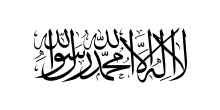

In [14]:
from IPython.display import Image

Image(urllib.request.urlopen('http:' + tables[0].find_all('img')[0]['src']).read())

In [18]:
from pathlib import Path

def download_flags(table, folder, idx_offset=0):
    folder  = Path(folder)
    images = table.find_all('img')
    for i, image in enumerate(images):
        src = image['src']
        name = src.split('/')[-1]

        with open(folder / f'{i+idx_offset}-{name}', mode='wb') as f:
            f.write(urllib.request.urlopen('http:' + src).read())

    return len(images) + idx_offset

In [19]:
last = 0
for table in tables:
    last = download_flags(tables[0], '../data/flags', idx_offset=last)

In [ ]:
flags = Path('../data/flags').glob()

def get_path(i):
    flags

In [27]:
import html

html.unescape(r'//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Flag_of_Afghanistan_%282013%E2%80%932021%29.svg/220px-Flag_of_Afghanistan_%282013%E2%80%932021%29.svg.png')

'//upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Flag_of_Afghanistan_%282013%E2%80%932021%29.svg/220px-Flag_of_Afghanistan_%282013%E2%80%932021%29.svg.png'